In [27]:

from pathlib import Path
import shutil

INPUT_ROOT = Path("/kaggle/input/bsds300/BSDS300/images")

HR_TRAIN_DIR = INPUT_ROOT / "train"
HR_VALID_DIR = INPUT_ROOT / "test"

print("Original Train HR path:", HR_TRAIN_DIR)
print("Original Valid HR path:", HR_VALID_DIR)

WORKING_DIR = Path("/kaggle/working/DIV2K")
WORKING_DIR.mkdir(parents=True, exist_ok=True)

DEST_TRAIN_DIR = WORKING_DIR / "DIV2K_train_HR"
DEST_VALID_DIR = WORKING_DIR / "DIV2K_valid_HR"

def copy_images(src_dir, dest_dir):
    dest_dir.mkdir(parents=True, exist_ok=True)
    for file in src_dir.rglob("*.*"):  
        if file.suffix.lower() in [".jpg", ".png"]:
            shutil.copy(file, dest_dir)

copy_images(HR_TRAIN_DIR, DEST_TRAIN_DIR)
copy_images(HR_VALID_DIR, DEST_VALID_DIR)

print("Copied Train HR path:", DEST_TRAIN_DIR)
print("Copied Valid HR path:", DEST_VALID_DIR)

train_files = sorted(DEST_TRAIN_DIR.glob("*.*"))
valid_files = sorted(DEST_VALID_DIR.glob("*.*"))

print(f"Total training images found: {len(train_files)}")
print(f"Total validation images found: {len(valid_files)}")

print("Sample train files:", train_files[:5])
print("Sample valid files:", valid_files[:5])


Original Train HR path: /kaggle/input/bsds300/BSDS300/images/train
Original Valid HR path: /kaggle/input/bsds300/BSDS300/images/test
Copied Train HR path: /kaggle/working/DIV2K/DIV2K_train_HR
Copied Valid HR path: /kaggle/working/DIV2K/DIV2K_valid_HR
Total training images found: 200
Total validation images found: 100
Sample train files: [PosixPath('/kaggle/working/DIV2K/DIV2K_train_HR/100075.jpg'), PosixPath('/kaggle/working/DIV2K/DIV2K_train_HR/100080.jpg'), PosixPath('/kaggle/working/DIV2K/DIV2K_train_HR/100098.jpg'), PosixPath('/kaggle/working/DIV2K/DIV2K_train_HR/103041.jpg'), PosixPath('/kaggle/working/DIV2K/DIV2K_train_HR/104022.jpg')]
Sample valid files: [PosixPath('/kaggle/working/DIV2K/DIV2K_valid_HR/101085.jpg'), PosixPath('/kaggle/working/DIV2K/DIV2K_valid_HR/101087.jpg'), PosixPath('/kaggle/working/DIV2K/DIV2K_valid_HR/102061.jpg'), PosixPath('/kaggle/working/DIV2K/DIV2K_valid_HR/103070.jpg'), PosixPath('/kaggle/working/DIV2K/DIV2K_valid_HR/105025.jpg')]


In [28]:
!ls /kaggle/input/bsds300/BSDS300/images

test  train


In [29]:
from pathlib import Path

# Root dataset directory
dataset_dir = Path("/kaggle/working/DIV2K")

# Add extra nested folder for train and validation
train_dir = dataset_dir / "DIV2K_train_HR" 
val_dir   = dataset_dir / "DIV2K_valid_HR" 

print("Train dir exists:", train_dir.exists())
print("Val dir exists:", val_dir.exists())

# Safely list first 3 PNG files
train_files = sorted(train_dir.rglob("*.jpg"))
val_files = sorted(val_dir.rglob("*.jpg"))

print("Example train files:", train_files[:3])
print("Example val files:", val_files[:3])

# Print total number of images
print(f"Total training images: {len(train_files)}")
print(f"Total validation images: {len(val_files)}")


Train dir exists: True
Val dir exists: True
Example train files: [PosixPath('/kaggle/working/DIV2K/DIV2K_train_HR/100075.jpg'), PosixPath('/kaggle/working/DIV2K/DIV2K_train_HR/100080.jpg'), PosixPath('/kaggle/working/DIV2K/DIV2K_train_HR/100098.jpg')]
Example val files: [PosixPath('/kaggle/working/DIV2K/DIV2K_valid_HR/101085.jpg'), PosixPath('/kaggle/working/DIV2K/DIV2K_valid_HR/101087.jpg'), PosixPath('/kaggle/working/DIV2K/DIV2K_valid_HR/102061.jpg')]
Total training images: 200
Total validation images: 100


In [30]:


import subprocess, os, sys, glob, importlib, importlib.util, traceback
from pathlib import Path
import torch

subprocess.run([
    "pip", "install", "--quiet",
    "opencv-python", "tqdm", "scikit-image", "lmdb",
    "pyyaml", "yapf", "addict"
])

if not os.path.exists("/kaggle/working/Restormer"):
    subprocess.run(["git", "clone", "https://github.com/swz30/Restormer.git", "/kaggle/working/Restormer"])
if not os.path.exists("/kaggle/working/KAIR"):
    subprocess.run(["git", "clone", "https://github.com/cszn/KAIR.git", "/kaggle/working/KAIR"])
    
def load_module_from_file(module_name, filepath):
    spec = importlib.util.spec_from_file_location(module_name, filepath)
    mod = importlib.util.module_from_spec(spec)
    try:
        spec.loader.exec_module(mod)
    except Exception:
        traceback.print_exc()
        return None
    return mod

candidates = [
    "/kaggle/working/Restormer",
    "/kaggle/working/Restormer/basicsr",
    "/kaggle/working/Restormer/basicsr/models",
    "/kaggle/working/Restormer/basicsr/models/archs",
    "/kaggle/working/KAIR",
    "/kaggle/working/KAIR/models",
    "/kaggle/working/KAIR/models/archs",
]
for p in candidates:
    if p not in sys.path and os.path.exists(p):
        sys.path.insert(0, p)

print("sys.path extended with repo dirs:")
for p in candidates:
    if os.path.exists(p):
        print("  -", p)

RestormerClass = None
rest_paths = glob.glob('/kaggle/working/**/restormer_arch.py', recursive=True)
if rest_paths:
    chosen = rest_paths[0]
    module = load_module_from_file("restormer_arch_dynamic", chosen)
    if module is not None:
        RestormerClass = getattr(module, "Restormer", None)
        if RestormerClass:
            print(" Restormer class imported from file.")
else:
    try:
        from basicsr.models.archs.restormer_arch import Restormer as _Rest1
        RestormerClass = _Rest1
        print(" Restormer imported from basicsr.models.archs.restormer_arch.Restormer")
    except:
        print(" Could not auto-import Restormer by name.")

DRUNetClass = None
SELECT_NETWORK = None
try:
    import models.select_network as select_network
    SELECT_NETWORK = select_network
    print(" KAIR select_network factory available")
except Exception as e:
    print(" KAIR select_network import failed:", e)

def build_drunet(in_nc=6, out_nc=3, nc_list=[64,128,256,512], nb=4,
                 act_mode='R', device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    if DRUNetClass is not None:
        try:
            model = DRUNetClass(in_nc=in_nc, out_nc=out_nc, nc=nc_list, nb=nb, act_mode=act_mode).to(device)
            return model, "DRUNet built from class import"
        except:
            pass
    if SELECT_NETWORK is not None:
        opt = {'network':'drunet','in_nc':in_nc,'out_nc':out_nc,'nc':nc_list,'nb':nb,'act_mode':act_mode}
        model = SELECT_NETWORK.define_network(opt).to(device)
        return model, "DRUNet built via KAIR factory"
    return None, "No DRUNet implementation available"

def build_restormer(device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    if RestormerClass is not None:
        for attempt in [
            lambda: RestormerClass(),
            lambda: RestormerClass(img_size=512, in_c=3, out_c=3),
            lambda: RestormerClass(inp_channels=3, out_channels=3)
        ]:
            try:
                inst = attempt().to(device)
                return inst, "Restormer built with common constructor"
            except:
                continue
    return None, "Restormer class not available"

print("\n--- Summary ---")
print("RestormerClass:", "AVAILABLE" if RestormerClass else "NOT FOUND")
print("DRUNetClass:", "AVAILABLE" if DRUNetClass else ("KAIR factory AVAILABLE" if SELECT_NETWORK else "NOT FOUND"))
print("\nHelper usage examples:")
print("  model, src = build_drunet(); print(src)")
print("  rest_model, src = build_restormer(); print(src)")

RESTORMER_CLASS = RestormerClass
DRUNET_CLASS   = DRUNetClass
SELECT_NETWORK_FACTORY = SELECT_NETWORK

print("\n Cell 3 finished (BM3D removed; only Restormer + DRUNet).")


sys.path extended with repo dirs:
  - /kaggle/working/Restormer
  - /kaggle/working/Restormer/basicsr
  - /kaggle/working/Restormer/basicsr/models
  - /kaggle/working/Restormer/basicsr/models/archs
  - /kaggle/working/KAIR
  - /kaggle/working/KAIR/models
✅ Restormer class imported from file.
⚠️ KAIR select_network import failed: No module named 'models.select_network'

--- Summary ---
RestormerClass: AVAILABLE
DRUNetClass: NOT FOUND

Helper usage examples:
  model, src = build_drunet(); print(src)
  rest_model, src = build_restormer(); print(src)

✅ Cell 3 finished (BM3D removed; only Restormer + DRUNet).


In [31]:

def img_to_tensor(img):
    arr = np.array(img) if not isinstance(img, np.ndarray) else img
    if arr.dtype == np.uint8:
        arr = arr.astype(np.float32)/255.0
    if arr.max() > 1.0:
        arr = arr.astype(np.float32)/255.0
    arr = np.transpose(arr, (2,0,1))
    return torch.from_numpy(arr).float()

def tensor_to_img(t):
    if isinstance(t, torch.Tensor):
        a = t.detach().cpu().numpy()
    else:
        a = np.array(t)
    if a.ndim == 4:
        a = a[0]
    a = np.transpose(a, (1,2,0))
    a = np.clip(a, 0.0, 1.0)
    return (a * 255.0).astype(np.uint8)

def compute_psnr_numpy(x, y, data_range=None):
    x = np.array(x, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    if x.shape != y.shape:
        raise ValueError(f"Shape mismatch: {x.shape} vs {y.shape}")

    # auto-detect data_range
    if data_range is None:
        if x.max() > 1.0 or y.max() > 1.0:
            data_range = 255.0
        else:
            data_range = 1.0

    mse = float(np.mean((x - y) ** 2))
    if mse == 0:
        return 100.0
    return 10.0 * math.log10((data_range ** 2) / mse)

def save_img(path, arr):
    if isinstance(arr, torch.Tensor):
        arr = arr.detach().cpu().numpy()
    if arr.ndim == 3 and arr.shape[0] in (1,3):  # CHW -> HWC
        arr = np.transpose(arr, (1,2,0))
    if arr.max() <= 1.0:
        arr = arr * 255.0
    arr = np.clip(arr, 0, 255).astype(np.uint8)
    Image.fromarray(arr).save(path)


In [32]:

from torch.utils.data import Dataset 

class PatchDataset(Dataset):
    def __init__(self, folder, patch_size=64, sigma=50.0, augment=True, prefilter_folder=None):
        self.paths = sorted([p for ext in ('*.png','*.jpg','*.jpeg','*.bmp')
                             for p in Path(folder).rglob(ext)])
        if len(self.paths) == 0:
            raise RuntimeError(f"No images found in {folder}.")
        self.patch_size = patch_size
        self.sigma = sigma
        self.augment = augment
        self.prefilter_folder = Path(prefilter_folder) if prefilter_folder else None

    def __len__(self):
        return len(self.paths)

    def random_crop(self, img):
        H, W, _ = img.shape
        ph = min(self.patch_size, H)
        pw = min(self.patch_size, W)
        top = random.randint(0, H - ph) if H > ph else 0
        left = random.randint(0, W - pw) if W > pw else 0
        return img[top:top+ph, left:left+pw].copy()

    def augment_patch(self, patch):
        if not self.augment:
            return patch
        # random flip / rotate / color jitter
        if random.random() < 0.5: patch = np.fliplr(patch).copy()
        if random.random() < 0.5: patch = np.flipud(patch).copy()
        k = random.randint(0,3)
        if k > 0: patch = np.rot90(patch, k).copy()
        if random.random() < 0.5:
            factor = 1.0 + np.random.uniform(-0.1, 0.1)
            patch = np.clip(patch * factor, 0.0, 1.0)
        return patch

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert('RGB')
        img = np.array(img).astype(np.float32) / 255.0
        patch = self.random_crop(img)
        patch = self.augment_patch(patch)

        clean = patch
        noise = np.random.normal(0, self.sigma/255.0, clean.shape).astype(np.float32)
        noisy = np.clip(clean + noise, 0.0, 1.0)

        noisy_t = img_to_tensor(noisy)
        clean_t = img_to_tensor(clean)

        rest_t = noisy_t.clone()  
        if self.prefilter_folder:
            rest_path = self.prefilter_folder / p.name
            if rest_path.exists():
                rest_img = np.array(Image.open(rest_path).convert('RGB')).astype(np.float32)/255.0
                rest_t = img_to_tensor(rest_img)

        return noisy_t, rest_t, clean_t

In [33]:

import os

ckpt_dir = "/kaggle/working/Restormer"
ckpt_name = "gaussian_color_denoising_sigma25.pth"
ckpt_path = os.path.join(ckpt_dir, ckpt_name)

# remove if corrupted or wrong
if os.path.exists(ckpt_path):
    os.remove(ckpt_path)
    print(" Removed old checkpoint (maybe corrupted).")

url = "https://github.com/swz30/Restormer/releases/download/v1.0/" + ckpt_name

print(" Downloading Restormer denoising checkpoint:", ckpt_name)
!wget -O {ckpt_path} {url}
print(" Download finished:", ckpt_path)

size_mb = os.path.getsize(ckpt_path) / (1024*1024)
print(f"File size: {size_mb:.2f} MB (should be ~100 MB)")


❌ Removed old checkpoint (maybe corrupted).
⬇️ Downloading Restormer denoising checkpoint: gaussian_color_denoising_sigma25.pth
--2025-09-30 09:01:59--  https://github.com/swz30/Restormer/releases/download/v1.0/gaussian_color_denoising_sigma25.pth
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/418793252/a2260e13-2cac-4656-b262-8166061b8670?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-30T09%3A36%3A09Z&rscd=attachment%3B+filename%3Dgaussian_color_denoising_sigma25.pth&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-30T08%3A35%3A43Z&ske=2025-09-30T09%3A36%3A09Z&sks=b&skv=2018-11-09&sig=bfk7X5CJxWNQUoFL0d3vFFRdbz082Oa%2BsYbgI776nUE%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwi

In [34]:


import torch
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, in_nc, out_nc, act_mode='R'):
        super().__init__()
        act = nn.ReLU(inplace=True) if act_mode == 'R' else nn.LeakyReLU(0.2, inplace=True)
        self.block = nn.Sequential(
            nn.Conv2d(in_nc, out_nc, 3, 1, 1, bias=True),
            act,
            nn.Conv2d(out_nc, out_nc, 3, 1, 1, bias=True)
        )

    def forward(self, x):
        return x + self.block(x)

class DRUNet(nn.Module):
    def __init__(self, in_nc=3, out_nc=3, nc=[64,128,256,512], nb=4, act_mode='R'):
        super().__init__()
        act = nn.ReLU(inplace=True) if act_mode == 'R' else nn.LeakyReLU(0.2, inplace=True)

        # Encoder
        self.m_head = nn.Conv2d(in_nc, nc[0], 3, 1, 1, bias=True)
        self.encoder1 = self._make_layer(nc[0], nc[0], nb, act)
        self.down1 = nn.Conv2d(nc[0], nc[1], 2, 2, 0, bias=False)

        self.encoder2 = self._make_layer(nc[1], nc[1], nb, act)
        self.down2 = nn.Conv2d(nc[1], nc[2], 2, 2, 0, bias=False)

        self.encoder3 = self._make_layer(nc[2], nc[2], nb, act)
        self.down3 = nn.Conv2d(nc[2], nc[3], 2, 2, 0, bias=False)

        # Bottleneck
        self.bottleneck = self._make_layer(nc[3], nc[3], nb, act)

        # Decoder
        self.up3 = nn.ConvTranspose2d(nc[3], nc[2], 2, 2, 0, bias=False)
        self.decoder3 = self._make_layer(nc[3], nc[2], nb, act)

        self.up2 = nn.ConvTranspose2d(nc[2], nc[1], 2, 2, 0, bias=False)
        self.decoder2 = self._make_layer(nc[2], nc[1], nb, act)

        self.up1 = nn.ConvTranspose2d(nc[1], nc[0], 2, 2, 0, bias=False)
        self.decoder1 = self._make_layer(nc[1], nc[0], nb, act)

        # Output
        self.m_tail = nn.Conv2d(nc[0], out_nc, 3, 1, 1, bias=True)

    def _make_layer(self, in_nc, out_nc, nb, act):
        layers = []
        for _ in range(nb):
            layers.append(ResBlock(in_nc, out_nc, act_mode='R'))
        return nn.Sequential(*layers)

    def forward(self, x):
        h0 = self.m_head(x)
        h1 = self.encoder1(h0)
        h2 = self.encoder2(self.down1(h1))
        h3 = self.encoder3(self.down2(h2))
        h4 = self.bottleneck(self.down3(h3))

        d3 = self.decoder3(torch.cat([self.up3(h4), h3], dim=1))
        d2 = self.decoder2(torch.cat([self.up2(d3), h2], dim=1))
        d1 = self.decoder1(torch.cat([self.up1(d2), h1], dim=1))

        out = self.m_tail(d1) + x[:, :3, :, :]  # residual connection
        return out

print(" DRUNet architecture loaded")


✅ DRUNet architecture loaded


In [35]:

from skimage.metrics import peak_signal_noise_ratio as sk_psnr
import numpy as np
import torch
from tqdm import tqdm

def evaluate_model_psnr(model, data_loader, device, sigma=50.0, tta=False, post_bm3d=False):
    model.eval()
    psnrs = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="val"):
           
            noisy_t, bm3d_t, clean_t = batch

            noisy_t = noisy_t.to(device)
            clean_t = clean_t.to(device)

            if bm3d_t is None:
            
                bm_list = []
                for i in range(noisy_t.size(0)):
                    n_np = noisy_t[i].cpu().numpy().transpose(1, 2, 0)
                    b_np = apply_bm3d_to_rgb(n_np, sigma / 255.0)
                    b_t = torch.from_numpy(b_np.transpose(2, 0, 1)).float()
                    bm_list.append(b_t)
                bm3d_t = torch.stack(bm_list).to(device)
            else:
                bm3d_t = bm3d_t.to(device)

            inp = torch.cat([noisy_t, bm3d_t], dim=1)

            if tta:
                flips = [None, 'h', 'v', 'hv']
                outputs = []
                for f in flips:
                    x = inp.clone()
                    if f == 'h':
                        x = torch.flip(x, dims=[3])
                    elif f == 'v':
                        x = torch.flip(x, dims=[2])
                    elif f == 'hv':
                        x = torch.flip(x, dims=[2, 3])
                    out_res = model(x)
                    # reverse flip
                    if f == 'h':
                        out_res = torch.flip(out_res, dims=[3])
                    elif f == 'v':
                        out_res = torch.flip(out_res, dims=[2])
                    elif f == 'hv':
                        out_res = torch.flip(out_res, dims=[2, 3])
                    outputs.append(out_res)
                out_res = torch.stack(outputs, dim=0).mean(dim=0)
            else:
                out_res = model(inp)

            denoised = (inp[:, :3, :, :] - out_res).clamp(0.0, 1.0)

            if post_bm3d:
                den_list = []
                for i in range(denoised.size(0)):
                    den_np = denoised[i].cpu().permute(1, 2, 0).numpy()
                    den_bm3d = apply_bm3d_to_rgb(den_np, sigma=5.0/255.0)  # small sigma for refinement
                    den_list.append(torch.from_numpy(den_bm3d.transpose(2, 0, 1)).float())
                denoised = torch.stack(den_list).to(device)

            # compute PSNR
            den_np_batch = denoised.cpu().permute(0, 2, 3, 1).numpy()
            clean_np_batch = clean_t.cpu().permute(0, 2, 3, 1).numpy()
            for i in range(den_np_batch.shape[0]):
                ps = sk_psnr(clean_np_batch[i], den_np_batch[i], data_range=1.0)
                psnrs.append(ps)

    avg = float(np.mean(psnrs)) if len(psnrs) else 0.0
    return avg


In [36]:

from torch.cuda.amp import autocast, GradScaler
from pathlib import Path
import torch, torch.nn as nn, torch.optim as optim
import os
from tqdm import tqdm
import numpy as np

class CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-3):
        super().__init__()
        self.eps = eps
    def forward(self, pred, target):
        diff = pred - target
        loss = torch.mean(torch.sqrt(diff * diff + (self.eps*self.eps)))
        return loss

def train_model(model, train_loader, val_loader, device,
                epochs=200, sigma=50.0, lr=5e-4, save_dir='checkpoints',
                loss_type='charbonnier', use_amp=True, clip_grad=1.0, resume_from=None):

    os.makedirs(save_dir, exist_ok=True)
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
    criterion = CharbonnierLoss().to(device) if loss_type=='charbonnier' else nn.MSELoss().to(device)
    scaler = GradScaler(enabled=(use_amp and device.type=='cuda'))

    start_epoch = 1
    best_val = -1.0
    if resume_from is not None and Path(resume_from).exists():
        ck = torch.load(resume_from, map_location=device)
        model.load_state_dict(ck['model_state'])
        start_epoch = ck.get('epoch', 1) + 1
        print("Resumed from", resume_from, "epoch", start_epoch)

    for epoch in range(start_epoch, epochs+1):
        model.train()
        running_loss = 0.0
        n_samples = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} train")
        for batch_idx, batch in enumerate(pbar):
            noisy_t, rest_t, clean_t = batch
            noisy_t = noisy_t.to(device)
            rest_t   = rest_t.to(device)
            clean_t  = clean_t.to(device)

            
            inp = torch.cat([noisy_t, rest_t], dim=1)

            optimizer.zero_grad()
            with autocast(enabled=(use_amp and device.type=='cuda')):
                pred_res = model(inp)    
                denoised = (inp[:, :3, :, :] - pred_res)
                loss = criterion(denoised, clean_t)

            scaler.scale(loss).backward()
            if clip_grad:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            scaler.step(optimizer)
            scaler.update()

            running_loss += float(loss.item()) * noisy_t.size(0)
            n_samples += noisy_t.size(0)
            pbar.set_postfix(train_loss = running_loss / max(1, n_samples))

       
        val_psnr = evaluate_model_psnr(model, val_loader, device, sigma=sigma, tta=False, post_bm3d=False)
        print(f"Epoch {epoch} | val PSNR: {val_psnr:.4f}")


        ckpt_path = Path(save_dir)/f"ckpt_epoch{epoch}.pth"
        torch.save({'epoch': epoch, 'model_state': model.state_dict(), 'val_psnr': val_psnr}, ckpt_path)
        if val_psnr > best_val:
            best_val = val_psnr
            torch.save({'epoch': epoch, 'model_state': model.state_dict(), 'val_psnr': val_psnr}, Path(save_dir)/'best.pth')
            print("Saved best model with PSNR:", best_val)

        scheduler.step()

    return model


In [37]:

import os
from pathlib import Path
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm


train_folder = "/kaggle/working/DIV2K/DIV2K_train_HR"   
val_folder   = "/kaggle/working/DIV2K/DIV2K_valid_HR"    

rest_train_folder = "/kaggle/working/DIV2K_restored/train"
rest_val_folder   = "/kaggle/working/DIV2K_restored/val"


os.makedirs(rest_train_folder, exist_ok=True)
os.makedirs(rest_val_folder, exist_ok=True)

restormer_model, src = build_restormer()
restormer_model.eval()
print("Using Restormer:", src)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PIXEL_UNSHUFFLE_FACTOR = 2
MAX_PATCH = 128
STRIDE = 128

def pad_to_multiple_of_eight(t):
    """Pad BCHW tensor so H,W are divisible by 8."""
    b, c, h, w = t.shape
    pad_h = (8 - h % 8) % 8
    pad_w = (8 - w % 8) % 8
   
    return F.pad(t, (0, pad_w, 0, pad_h), mode="replicate"), pad_h, pad_w

def preprocess_folder_robust(src_folder, dst_folder):
    paths = sorted([p for ext in ('*.png','*.jpg','*.jpeg','*.bmp')
                    for p in Path(src_folder).rglob(ext)])

    for p in tqdm(paths, desc=f"Processing {src_folder}"):
        img = Image.open(p).convert("RGB")
        H, W = img.height, img.width
        out_img = np.zeros((H, W, 3), dtype=np.float32)
        weight_map = np.zeros((H, W, 3), dtype=np.float32)

        for i in range(0, H, STRIDE):
            for j in range(0, W, STRIDE):
                h_patch = min(MAX_PATCH, H - i)
                w_patch = min(MAX_PATCH, W - j)

              
                if h_patch < 8 or w_patch < 8:
                    continue

                patch = np.array(img.crop((j, i, j + w_patch, i + h_patch))) / 255.0
                inp = img_to_tensor(patch).unsqueeze(0).to(DEVICE)

              
                inp_pad, pad_h, pad_w = pad_to_multiple_of_eight(inp)

                try:
                    with torch.no_grad():
                        out_patch = restormer_model(inp_pad)
                        out_patch = out_patch[:, :, :inp_pad.shape[2]-pad_h, :inp_pad.shape[3]-pad_w]
                except RuntimeError as e:
                    print(f" Error on {p.name} patch ({i}:{i+h_patch}, {j}:{j+w_patch}), resizing and retrying: {e}")
                    safe_patch = Image.fromarray((patch*255).astype(np.uint8)).resize(
                        (MAX_PATCH, MAX_PATCH), Image.BICUBIC
                    )
                    safe_inp = img_to_tensor(np.array(safe_patch)/255.0).unsqueeze(0).to(DEVICE)
                    safe_inp, pad_h, pad_w = pad_to_multiple_of_eight(safe_inp)
                    with torch.no_grad():
                        out_patch = restormer_model(safe_inp)
                    out_patch = out_patch[:, :, :h_patch, :w_patch]

                out_img[i:i+h_patch, j:j+w_patch, :] += out_patch[0].cpu().numpy().transpose(1,2,0)
                weight_map[i:i+h_patch, j:j+w_patch, :] += 1.0

        out_img = out_img / np.maximum(weight_map, 1e-8)
        out_img = np.clip(out_img * 255.0, 0, 255).astype(np.uint8)
        Image.fromarray(out_img).save(Path(dst_folder)/p.name)

    print(f" Completed preprocessing for {src_folder}")


preprocess_folder_robust(train_folder, rest_train_folder)
preprocess_folder_robust(val_folder, rest_val_folder)

print(" Restormer preprocessing finished. No skips, auto-fixed problematic images.")


Using Restormer: Restormer built with common constructor


Processing /kaggle/working/DIV2K/DIV2K_train_HR: 100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


✅ Completed preprocessing for /kaggle/working/DIV2K/DIV2K_train_HR


Processing /kaggle/working/DIV2K/DIV2K_valid_HR: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]

✅ Completed preprocessing for /kaggle/working/DIV2K/DIV2K_valid_HR
✅ Restormer preprocessing finished. No skips, auto-fixed problematic images.


In [39]:

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch import amp
from torchvision import transforms
from PIL import Image
from pathlib import Path
import random, os
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

PATCH_SIZE = 192
BATCH_SIZE = 16
MAX_CHECKPOINTS = 5
AUTO_RESUME = True

class PatchDataset(Dataset):
    def __init__(self, folder, patch_size=PATCH_SIZE, sigma=50.0, augment=False, prefilter_folder=None):
        self.folder = Path(folder)
        self.files = sorted(self.folder.glob("*.jpg"))
        self.patch_size = patch_size
        self.sigma = sigma
        self.augment = augment
        self.prefilter_folder = Path(prefilter_folder) if prefilter_folder else None
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.files)

    def random_crop(self, img):
        W, H = img.size
        ph = pw = self.patch_size
        left = random.randint(0, max(W - pw, 0))
        top  = random.randint(0, max(H - ph, 0))
        return img.crop((left, top, left + pw, top + ph))

    def __getitem__(self, idx):
        clean_path = self.files[idx]
        clean_img = Image.open(clean_path).convert("RGB")
        clean_img = self.random_crop(clean_img)
        clean_t = self.to_tensor(clean_img)

        noisy_t = clean_t + (torch.randn_like(clean_t) * (self.sigma / 255.0))
        noisy_t = torch.clamp(noisy_t, 0.0, 1.0)

        if self.prefilter_folder and (self.prefilter_folder / clean_path.name).exists():
            rest_img = Image.open(self.prefilter_folder / clean_path.name).convert("RGB")
            rest_img = self.random_crop(rest_img)
            rest_t = self.to_tensor(rest_img)
        else:
            rest_t = clean_t.clone()

        return noisy_t, rest_t, clean_t

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1)
        )
    def forward(self, x):
        return x + self.block(x)

class DRUNet(nn.Module):
    def __init__(self, in_nc=6, out_nc=3, nc=[64,128,256,512], nb=4):
        super().__init__()
        self.down1 = nn.Sequential(nn.Conv2d(in_nc, nc[0], 3, padding=1), nn.ReLU(inplace=True))
        self.down2 = nn.Sequential(nn.Conv2d(nc[0], nc[1], 3, stride=2, padding=1), nn.ReLU(inplace=True))
        self.down3 = nn.Sequential(nn.Conv2d(nc[1], nc[2], 3, stride=2, padding=1), nn.ReLU(inplace=True))
        self.bottleneck = nn.Sequential(*[ResidualBlock(nc[2]) for _ in range(nb)])
        self.up3 = nn.ConvTranspose2d(nc[2], nc[1], 2, stride=2)
        self.decoder3 = nn.Sequential(*[ResidualBlock(nc[1]) for _ in range(nb)])
        self.up2 = nn.ConvTranspose2d(nc[1], nc[0], 2, stride=2)
        self.decoder2 = nn.Sequential(*[ResidualBlock(nc[0]) for _ in range(nb)])
        self.decoder1 = nn.Conv2d(nc[0], out_nc, 3, padding=1)

    def forward(self, x):
        h1 = self.down1(x)
        h2 = self.down2(h1)
        h3 = self.down3(h2)
        h4 = self.bottleneck(h3)
        d3 = self.decoder3(self.up3(h4) + h2)
        d2 = self.decoder2(self.up2(d3) + h1)
        out = self.decoder1(d2)
        return out

def charbonnier_loss(x, y, eps=1e-6):
    return torch.mean(torch.sqrt((x - y)**2 + eps**2))

# ----------------- TRAIN FUNCTION -----------------
def train_model(model, train_loader, val_loader, device, epochs=200, lr=2e-4,
                save_dir="./checkpoints", use_amp=True, clip_grad=1.0, max_checkpoints=MAX_CHECKPOINTS,
                auto_resume=AUTO_RESUME):

    os.makedirs(save_dir, exist_ok=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = amp.GradScaler(enabled=(use_amp and device.type=='cuda'))

    start_epoch = 0
    # Auto-resume
    if auto_resume:
        ckpt_files = sorted(Path(save_dir).glob("drunet_epoch*.pth"), key=os.path.getmtime)
        if ckpt_files:
            last_ckpt = ckpt_files[-1]
            print(f" Resuming from checkpoint: {last_ckpt}")
            checkpoint = torch.load(last_ckpt, map_location='cpu')
            model.load_state_dict(checkpoint['model'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            start_epoch = checkpoint['epoch']

    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} train")

        for noisy_t, rest_t, clean_t in pbar:
            noisy_t, rest_t, clean_t = noisy_t.to(device), rest_t.to(device), clean_t.to(device)
            inp = torch.cat([noisy_t, rest_t], dim=1)
            optimizer.zero_grad()

            with amp.autocast(device_type='cuda', enabled=(use_amp and device.type=='cuda')):
                pred_res = model(inp)
                denoised = inp[:, :3, :, :] - pred_res
                loss = charbonnier_loss(denoised, clean_t)

            scaler.scale(loss).backward()
            if clip_grad > 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            pbar.set_postfix({"loss": f"{running_loss/(pbar.n+1):.4f}"})

        # ----------------- VALIDATION -----------------
        model.eval()
        psnr_total = 0.0
        ssim_total = 0.0
        n_samples = 0

        with torch.no_grad():
            for noisy_t, rest_t, clean_t in val_loader:
                noisy_t, rest_t, clean_t = noisy_t.to(device), rest_t.to(device), clean_t.to(device)
                inp = torch.cat([noisy_t, rest_t], dim=1)
                pred_res = model(inp)
                denoised = inp[:, :3, :, :] - pred_res

                denoised_np = denoised.permute(0,2,3,1).cpu().numpy()
                clean_np = clean_t.permute(0,2,3,1).cpu().numpy()

                for i in range(denoised_np.shape[0]):
                    psnr_total += compute_psnr(clean_np[i], denoised_np[i], data_range=1.0)
                    ssim_total += compute_ssim(clean_np[i], denoised_np[i], channel_axis=-1, data_range=1.0)
                    n_samples += 1

        avg_psnr = psnr_total / n_samples
        avg_ssim = ssim_total / n_samples
        print(f" Epoch {epoch+1}: Val PSNR={avg_psnr:.4f}, SSIM={avg_ssim:.4f}")

       
        ckpt_path = os.path.join(save_dir, f"drunet_epoch{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model': {k: v.cpu() for k, v in model.state_dict().items()},
            'optimizer': optimizer.state_dict()
        }, ckpt_path)

        # Keep last N checkpoints
        all_ckpts = sorted(Path(save_dir).glob("drunet_epoch*.pth"), key=os.path.getmtime)
        while len(all_ckpts) > max_checkpoints:
            os.remove(all_ckpts[0])
            all_ckpts.pop(0)

   
    final_model_path = os.path.join(save_dir, "drunet_final.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f" Final model saved at {final_model_path}")

    return model


dataset_dir = Path("/kaggle/working/DIV2K")
train_folder = dataset_dir/"DIV2K_train_HR"
val_folder   = dataset_dir/"DIV2K_valid_HR"
rest_train_folder = Path("/kaggle/working/restormer_train")
rest_val_folder   = Path("/kaggle/working/restormer_val")


train_ds = PatchDataset(train_folder, patch_size=PATCH_SIZE, sigma=50.0, augment=True, prefilter_folder=rest_train_folder)
val_ds   = PatchDataset(val_folder, patch_size=PATCH_SIZE, sigma=50.0, augment=False, prefilter_folder=rest_val_folder)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f" Train samples: {len(train_ds)} | Val samples: {len(val_ds)}")


model = DRUNet(in_nc=6, out_nc=3, nc=[64,128,256,512])
model = model.to(DEVICE)
print(" DRUNet initialized")


trained_model = train_model(model, train_loader, val_loader, device=DEVICE, epochs=300, lr=2e-4, auto_resume=False)


Using device: cuda
✅ Train samples: 200 | Val samples: 100
✅ DRUNet initialized


Epoch 1/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s, loss=0.1469]


✅ Epoch 1: Val PSNR=15.9654, SSIM=0.2761


Epoch 2/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.1122]


✅ Epoch 2: Val PSNR=18.8453, SSIM=0.3623


Epoch 3/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0753]


✅ Epoch 3: Val PSNR=22.2879, SSIM=0.5149


Epoch 4/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0532]


✅ Epoch 4: Val PSNR=24.4087, SSIM=0.6495


Epoch 5/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0438]


✅ Epoch 5: Val PSNR=25.9475, SSIM=0.7468


Epoch 6/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0366]


✅ Epoch 6: Val PSNR=27.4033, SSIM=0.8006


Epoch 7/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0303]


✅ Epoch 7: Val PSNR=28.3306, SSIM=0.8545


Epoch 8/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0285]


✅ Epoch 8: Val PSNR=28.7372, SSIM=0.8743


Epoch 9/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0257]


✅ Epoch 9: Val PSNR=30.3239, SSIM=0.8926


Epoch 10/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0220]


✅ Epoch 10: Val PSNR=30.8493, SSIM=0.9073


Epoch 11/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0216]


✅ Epoch 11: Val PSNR=30.6525, SSIM=0.9160


Epoch 12/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0212]


✅ Epoch 12: Val PSNR=31.1597, SSIM=0.9213


Epoch 27/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0154]


✅ Epoch 27: Val PSNR=33.0032, SSIM=0.9543


Epoch 28/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0134]


✅ Epoch 28: Val PSNR=34.1127, SSIM=0.9622


Epoch 29/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0123]


✅ Epoch 29: Val PSNR=34.3224, SSIM=0.9661


Epoch 30/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0149]


✅ Epoch 30: Val PSNR=31.8546, SSIM=0.9621


Epoch 31/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0161]


✅ Epoch 31: Val PSNR=32.8096, SSIM=0.9608


Epoch 32/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0151]


✅ Epoch 32: Val PSNR=33.8984, SSIM=0.9631


Epoch 33/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0141]


✅ Epoch 33: Val PSNR=33.7366, SSIM=0.9656


Epoch 34/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0128]


✅ Epoch 34: Val PSNR=33.8913, SSIM=0.9682


Epoch 35/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0126]


✅ Epoch 35: Val PSNR=34.5695, SSIM=0.9672


Epoch 36/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0110]


✅ Epoch 36: Val PSNR=35.0816, SSIM=0.9718


Epoch 37/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0116]


✅ Epoch 37: Val PSNR=34.1155, SSIM=0.9711


Epoch 38/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0125]


✅ Epoch 38: Val PSNR=34.8417, SSIM=0.9686


Epoch 39/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0111]


✅ Epoch 39: Val PSNR=33.8684, SSIM=0.9713


Epoch 40/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0131]


✅ Epoch 40: Val PSNR=32.9171, SSIM=0.9697


Epoch 41/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0118]


✅ Epoch 41: Val PSNR=34.5219, SSIM=0.9718


Epoch 42/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0117]


✅ Epoch 42: Val PSNR=34.9223, SSIM=0.9737


Epoch 43/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0129]


✅ Epoch 43: Val PSNR=35.1370, SSIM=0.9755


Epoch 44/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0123]


✅ Epoch 44: Val PSNR=35.3163, SSIM=0.9756


Epoch 45/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0112]


✅ Epoch 45: Val PSNR=35.0358, SSIM=0.9744


Epoch 46/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0109]


✅ Epoch 46: Val PSNR=34.9378, SSIM=0.9770


Epoch 47/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0122]


✅ Epoch 47: Val PSNR=35.3391, SSIM=0.9769


Epoch 48/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0125]


✅ Epoch 48: Val PSNR=34.7971, SSIM=0.9748


Epoch 49/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0118]


✅ Epoch 49: Val PSNR=34.4761, SSIM=0.9744


Epoch 50/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0109]


✅ Epoch 50: Val PSNR=35.6024, SSIM=0.9774


Epoch 51/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0101]


✅ Epoch 51: Val PSNR=35.6535, SSIM=0.9778


Epoch 52/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0093]


✅ Epoch 52: Val PSNR=35.6305, SSIM=0.9792


Epoch 53/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0095]


✅ Epoch 53: Val PSNR=36.0484, SSIM=0.9798


Epoch 54/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0116]


✅ Epoch 54: Val PSNR=34.0521, SSIM=0.9769


Epoch 55/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0123]


✅ Epoch 55: Val PSNR=34.3849, SSIM=0.9743


Epoch 56/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0113]


✅ Epoch 56: Val PSNR=34.9960, SSIM=0.9774


Epoch 57/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0102]


✅ Epoch 57: Val PSNR=35.8645, SSIM=0.9794


Epoch 58/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0117]


✅ Epoch 58: Val PSNR=35.3292, SSIM=0.9777


Epoch 59/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0112]


✅ Epoch 59: Val PSNR=35.1340, SSIM=0.9800


Epoch 60/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0092]


✅ Epoch 60: Val PSNR=36.0447, SSIM=0.9821


Epoch 61/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0100]


✅ Epoch 61: Val PSNR=34.8167, SSIM=0.9806


Epoch 62/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0103]


✅ Epoch 62: Val PSNR=36.0735, SSIM=0.9811


Epoch 63/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0096]


✅ Epoch 63: Val PSNR=35.9456, SSIM=0.9815


Epoch 64/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s, loss=0.0107]


✅ Epoch 64: Val PSNR=35.4707, SSIM=0.9799


Epoch 65/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0089]


✅ Epoch 65: Val PSNR=36.4225, SSIM=0.9817


Epoch 66/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0114]


✅ Epoch 66: Val PSNR=34.1698, SSIM=0.9809


Epoch 67/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0123]


✅ Epoch 67: Val PSNR=35.5412, SSIM=0.9757


Epoch 68/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0095]


✅ Epoch 68: Val PSNR=36.2538, SSIM=0.9824


Epoch 69/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0084]


✅ Epoch 69: Val PSNR=36.5638, SSIM=0.9842


Epoch 70/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0083]


✅ Epoch 70: Val PSNR=36.6498, SSIM=0.9840


Epoch 71/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0081]


✅ Epoch 71: Val PSNR=36.8809, SSIM=0.9843


Epoch 72/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0082]


✅ Epoch 72: Val PSNR=35.4704, SSIM=0.9847


Epoch 73/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0119]


✅ Epoch 73: Val PSNR=36.1347, SSIM=0.9821


Epoch 74/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0091]


✅ Epoch 74: Val PSNR=36.6645, SSIM=0.9843


Epoch 75/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0100]


✅ Epoch 75: Val PSNR=36.8781, SSIM=0.9833


Epoch 76/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0094]


✅ Epoch 76: Val PSNR=36.0665, SSIM=0.9840


Epoch 77/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0105]


✅ Epoch 77: Val PSNR=36.6972, SSIM=0.9828


Epoch 78/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0082]


✅ Epoch 78: Val PSNR=36.8032, SSIM=0.9841


Epoch 79/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0087]


✅ Epoch 79: Val PSNR=36.3952, SSIM=0.9860


Epoch 80/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0090]


✅ Epoch 80: Val PSNR=36.7072, SSIM=0.9851


Epoch 81/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0089]


✅ Epoch 81: Val PSNR=37.1412, SSIM=0.9855


Epoch 82/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0082]


✅ Epoch 82: Val PSNR=36.9905, SSIM=0.9862


Epoch 83/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0072]


✅ Epoch 83: Val PSNR=37.5726, SSIM=0.9876


Epoch 84/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0089]


✅ Epoch 84: Val PSNR=34.9474, SSIM=0.9854


Epoch 85/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0103]


✅ Epoch 85: Val PSNR=37.2367, SSIM=0.9856


Epoch 86/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0079]


✅ Epoch 86: Val PSNR=36.7862, SSIM=0.9870


Epoch 87/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0076]


✅ Epoch 87: Val PSNR=37.6900, SSIM=0.9877


Epoch 88/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0082]


✅ Epoch 88: Val PSNR=37.1344, SSIM=0.9866


Epoch 89/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0095]


✅ Epoch 89: Val PSNR=35.0574, SSIM=0.9855


Epoch 90/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0090]


✅ Epoch 90: Val PSNR=37.9597, SSIM=0.9872


Epoch 91/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0073]


✅ Epoch 91: Val PSNR=35.7333, SSIM=0.9867


Epoch 92/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0095]


✅ Epoch 92: Val PSNR=37.5089, SSIM=0.9860


Epoch 93/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0084]


✅ Epoch 93: Val PSNR=37.7601, SSIM=0.9861


Epoch 94/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0077]


✅ Epoch 94: Val PSNR=37.2880, SSIM=0.9881


Epoch 95/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0081]


✅ Epoch 95: Val PSNR=37.4432, SSIM=0.9882


Epoch 96/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0090]


✅ Epoch 96: Val PSNR=35.5998, SSIM=0.9856


Epoch 97/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0098]


✅ Epoch 97: Val PSNR=37.5766, SSIM=0.9871


Epoch 98/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0078]


✅ Epoch 98: Val PSNR=37.8973, SSIM=0.9882


Epoch 99/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0075]


✅ Epoch 99: Val PSNR=37.9845, SSIM=0.9893


Epoch 100/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0068]


✅ Epoch 100: Val PSNR=38.5846, SSIM=0.9893


Epoch 101/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0064]


✅ Epoch 101: Val PSNR=38.6634, SSIM=0.9903


Epoch 102/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0064]


✅ Epoch 102: Val PSNR=39.3213, SSIM=0.9903


Epoch 103/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0070]


✅ Epoch 103: Val PSNR=38.9043, SSIM=0.9896


Epoch 104/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0077]


✅ Epoch 104: Val PSNR=38.8824, SSIM=0.9901


Epoch 105/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0063]


✅ Epoch 105: Val PSNR=39.5940, SSIM=0.9900


Epoch 106/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0071]


✅ Epoch 106: Val PSNR=38.1679, SSIM=0.9874


Epoch 107/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0064]


✅ Epoch 107: Val PSNR=39.1797, SSIM=0.9909


Epoch 108/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0060]


✅ Epoch 108: Val PSNR=39.5283, SSIM=0.9919


Epoch 109/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0062]


✅ Epoch 109: Val PSNR=39.8935, SSIM=0.9908


Epoch 110/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0063]


✅ Epoch 110: Val PSNR=39.6617, SSIM=0.9906


Epoch 111/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0059]


✅ Epoch 111: Val PSNR=39.9861, SSIM=0.9912


Epoch 112/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0056]


✅ Epoch 112: Val PSNR=39.7349, SSIM=0.9915


Epoch 113/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0075]


✅ Epoch 113: Val PSNR=38.3170, SSIM=0.9912


Epoch 114/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0069]


✅ Epoch 114: Val PSNR=40.2824, SSIM=0.9913


Epoch 115/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0059]


✅ Epoch 115: Val PSNR=39.8141, SSIM=0.9927


Epoch 116/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0059]


✅ Epoch 116: Val PSNR=40.5725, SSIM=0.9918


Epoch 117/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0062]


✅ Epoch 117: Val PSNR=37.8132, SSIM=0.9916


Epoch 118/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0076]


✅ Epoch 118: Val PSNR=39.7201, SSIM=0.9908


Epoch 119/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0068]


✅ Epoch 119: Val PSNR=40.5338, SSIM=0.9915


Epoch 120/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s, loss=0.0071]


✅ Epoch 120: Val PSNR=38.3844, SSIM=0.9890


Epoch 121/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0067]


✅ Epoch 121: Val PSNR=40.3798, SSIM=0.9916


Epoch 122/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0059]


✅ Epoch 122: Val PSNR=40.0833, SSIM=0.9928


Epoch 123/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0066]


✅ Epoch 123: Val PSNR=39.6171, SSIM=0.9913


Epoch 124/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0061]


✅ Epoch 124: Val PSNR=41.1091, SSIM=0.9927


Epoch 125/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0055]


✅ Epoch 125: Val PSNR=41.4125, SSIM=0.9929


Epoch 126/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0054]


✅ Epoch 126: Val PSNR=40.4928, SSIM=0.9929


Epoch 127/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0062]


✅ Epoch 127: Val PSNR=39.6201, SSIM=0.9923


Epoch 128/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0067]


✅ Epoch 128: Val PSNR=40.5503, SSIM=0.9908


Epoch 129/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0056]


✅ Epoch 129: Val PSNR=41.3716, SSIM=0.9931


Epoch 130/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0053]


✅ Epoch 130: Val PSNR=41.7729, SSIM=0.9941


Epoch 131/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0051]


✅ Epoch 131: Val PSNR=41.6063, SSIM=0.9941


Epoch 132/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0051]


✅ Epoch 132: Val PSNR=41.7855, SSIM=0.9939


Epoch 133/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0049]


✅ Epoch 133: Val PSNR=42.3000, SSIM=0.9937


Epoch 134/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, loss=0.0057]


✅ Epoch 134: Val PSNR=41.5901, SSIM=0.9931


Epoch 135/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, loss=0.0055]


✅ Epoch 135: Val PSNR=42.0695, SSIM=0.9929


Epoch 136/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0052]


✅ Epoch 136: Val PSNR=41.2786, SSIM=0.9936


Epoch 137/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0057]


✅ Epoch 137: Val PSNR=40.6820, SSIM=0.9936


Epoch 138/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0066]


✅ Epoch 138: Val PSNR=41.5668, SSIM=0.9926


Epoch 139/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0054]


✅ Epoch 139: Val PSNR=42.2647, SSIM=0.9934


Epoch 140/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0053]


✅ Epoch 140: Val PSNR=42.2209, SSIM=0.9945


Epoch 141/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0069]


✅ Epoch 141: Val PSNR=40.6962, SSIM=0.9932


Epoch 142/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0061]


✅ Epoch 142: Val PSNR=41.7751, SSIM=0.9936


Epoch 143/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0054]


✅ Epoch 143: Val PSNR=42.6004, SSIM=0.9943


Epoch 144/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0048]


✅ Epoch 144: Val PSNR=42.8144, SSIM=0.9942


Epoch 145/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0051]


✅ Epoch 145: Val PSNR=39.9132, SSIM=0.9929


Epoch 146/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0059]


✅ Epoch 146: Val PSNR=43.2824, SSIM=0.9947


Epoch 147/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0051]


✅ Epoch 147: Val PSNR=41.6926, SSIM=0.9944


Epoch 148/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0054]


✅ Epoch 148: Val PSNR=42.6983, SSIM=0.9945


Epoch 149/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0049]


✅ Epoch 149: Val PSNR=42.6497, SSIM=0.9946


Epoch 150/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0053]


✅ Epoch 150: Val PSNR=41.1123, SSIM=0.9940


Epoch 151/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0057]


✅ Epoch 151: Val PSNR=43.3691, SSIM=0.9943


Epoch 152/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0051]


✅ Epoch 152: Val PSNR=42.3877, SSIM=0.9942


Epoch 153/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0103]


✅ Epoch 153: Val PSNR=39.7876, SSIM=0.9895


Epoch 154/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0079]


✅ Epoch 154: Val PSNR=41.7981, SSIM=0.9912


Epoch 155/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0063]


✅ Epoch 155: Val PSNR=42.9309, SSIM=0.9940


Epoch 156/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0057]


✅ Epoch 156: Val PSNR=40.7149, SSIM=0.9933


Epoch 157/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0063]


✅ Epoch 157: Val PSNR=42.7874, SSIM=0.9944


Epoch 158/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0050]


✅ Epoch 158: Val PSNR=43.6777, SSIM=0.9945


Epoch 159/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0048]


✅ Epoch 159: Val PSNR=43.4413, SSIM=0.9952


Epoch 160/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0048]


✅ Epoch 160: Val PSNR=44.0619, SSIM=0.9948


Epoch 161/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0057]


✅ Epoch 161: Val PSNR=43.3438, SSIM=0.9953


Epoch 162/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0051]


✅ Epoch 162: Val PSNR=42.0914, SSIM=0.9943


Epoch 163/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0049]


✅ Epoch 163: Val PSNR=43.4723, SSIM=0.9949


Epoch 164/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0053]


✅ Epoch 164: Val PSNR=40.3601, SSIM=0.9942


Epoch 165/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0059]


✅ Epoch 165: Val PSNR=42.9815, SSIM=0.9953


Epoch 166/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0047]


✅ Epoch 166: Val PSNR=44.4039, SSIM=0.9954


Epoch 167/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0055]


✅ Epoch 167: Val PSNR=42.0901, SSIM=0.9954


Epoch 168/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0052]


✅ Epoch 168: Val PSNR=43.9028, SSIM=0.9949


Epoch 169/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0049]


✅ Epoch 169: Val PSNR=42.3028, SSIM=0.9947


Epoch 170/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0049]


✅ Epoch 170: Val PSNR=42.9179, SSIM=0.9947


Epoch 171/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0051]


✅ Epoch 171: Val PSNR=41.5759, SSIM=0.9950


Epoch 172/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0054]


✅ Epoch 172: Val PSNR=44.2883, SSIM=0.9956


Epoch 173/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0046]


✅ Epoch 173: Val PSNR=44.0383, SSIM=0.9959


Epoch 174/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0043]


✅ Epoch 174: Val PSNR=45.0439, SSIM=0.9956


Epoch 175/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0058]


✅ Epoch 175: Val PSNR=42.4463, SSIM=0.9949


Epoch 176/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0053]


✅ Epoch 176: Val PSNR=43.9883, SSIM=0.9954


Epoch 177/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0049]


✅ Epoch 177: Val PSNR=44.2296, SSIM=0.9954


Epoch 178/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0044]


✅ Epoch 178: Val PSNR=44.4393, SSIM=0.9959


Epoch 179/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0048]


✅ Epoch 179: Val PSNR=42.8090, SSIM=0.9951


Epoch 180/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0043]


✅ Epoch 180: Val PSNR=43.3442, SSIM=0.9950


Epoch 181/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0043]


✅ Epoch 181: Val PSNR=45.1544, SSIM=0.9960


Epoch 182/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0043]


✅ Epoch 182: Val PSNR=42.0131, SSIM=0.9958


Epoch 183/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0062]


✅ Epoch 183: Val PSNR=43.5800, SSIM=0.9957


Epoch 184/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0048]


✅ Epoch 184: Val PSNR=44.8316, SSIM=0.9959


Epoch 185/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0038]


✅ Epoch 185: Val PSNR=45.2738, SSIM=0.9960


Epoch 186/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0038]


✅ Epoch 186: Val PSNR=46.3982, SSIM=0.9961


Epoch 187/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0038]


✅ Epoch 187: Val PSNR=46.2987, SSIM=0.9964


Epoch 188/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0039]


✅ Epoch 188: Val PSNR=45.2373, SSIM=0.9960


Epoch 189/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0044]


✅ Epoch 189: Val PSNR=43.6983, SSIM=0.9959


Epoch 190/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0047]


✅ Epoch 190: Val PSNR=45.7964, SSIM=0.9964


Epoch 191/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0039]


✅ Epoch 191: Val PSNR=45.7193, SSIM=0.9966


Epoch 192/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0039]


✅ Epoch 192: Val PSNR=45.2950, SSIM=0.9964


Epoch 193/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0037]


✅ Epoch 193: Val PSNR=46.3098, SSIM=0.9963


Epoch 194/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0039]


✅ Epoch 194: Val PSNR=44.0145, SSIM=0.9964


Epoch 195/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0039]


✅ Epoch 195: Val PSNR=45.4477, SSIM=0.9966


Epoch 196/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0042]


✅ Epoch 196: Val PSNR=42.6131, SSIM=0.9965


Epoch 197/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0043]


✅ Epoch 197: Val PSNR=44.9297, SSIM=0.9967


Epoch 198/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0040]


✅ Epoch 198: Val PSNR=44.1532, SSIM=0.9965


Epoch 199/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0039]


✅ Epoch 199: Val PSNR=45.1730, SSIM=0.9968


Epoch 200/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0040]


✅ Epoch 200: Val PSNR=45.6981, SSIM=0.9966


Epoch 201/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0037]


✅ Epoch 201: Val PSNR=45.0261, SSIM=0.9966


Epoch 202/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0041]


✅ Epoch 202: Val PSNR=41.9600, SSIM=0.9967


Epoch 203/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0044]


✅ Epoch 203: Val PSNR=45.8468, SSIM=0.9968


Epoch 204/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0037]


✅ Epoch 204: Val PSNR=46.2980, SSIM=0.9970


Epoch 205/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0035]


✅ Epoch 205: Val PSNR=46.7489, SSIM=0.9971


Epoch 206/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0046]


✅ Epoch 206: Val PSNR=44.9521, SSIM=0.9967


Epoch 207/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0048]


✅ Epoch 207: Val PSNR=45.4985, SSIM=0.9969


Epoch 208/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0049]


✅ Epoch 208: Val PSNR=45.0223, SSIM=0.9964


Epoch 209/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0039]


✅ Epoch 209: Val PSNR=46.8026, SSIM=0.9966


Epoch 210/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0036]


✅ Epoch 210: Val PSNR=46.0083, SSIM=0.9968


Epoch 211/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0039]


✅ Epoch 211: Val PSNR=45.1728, SSIM=0.9970


Epoch 212/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0051]


✅ Epoch 212: Val PSNR=45.1068, SSIM=0.9965


Epoch 213/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0048]


✅ Epoch 213: Val PSNR=45.2397, SSIM=0.9963


Epoch 214/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0042]


✅ Epoch 214: Val PSNR=45.4096, SSIM=0.9966


Epoch 215/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0037]


✅ Epoch 215: Val PSNR=47.2973, SSIM=0.9970


Epoch 216/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0037]


✅ Epoch 216: Val PSNR=45.1262, SSIM=0.9967


Epoch 217/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0044]


✅ Epoch 217: Val PSNR=44.8562, SSIM=0.9974


Epoch 218/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0039]


✅ Epoch 218: Val PSNR=46.2970, SSIM=0.9972


Epoch 219/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0035]


✅ Epoch 219: Val PSNR=46.4793, SSIM=0.9967


Epoch 220/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0036]


✅ Epoch 220: Val PSNR=46.1101, SSIM=0.9976


Epoch 221/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0038]


✅ Epoch 221: Val PSNR=47.3286, SSIM=0.9970


Epoch 222/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, loss=0.0036]


✅ Epoch 222: Val PSNR=46.2466, SSIM=0.9972


Epoch 223/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, loss=0.0034]


✅ Epoch 223: Val PSNR=46.4537, SSIM=0.9976


Epoch 224/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0034]


✅ Epoch 224: Val PSNR=46.2460, SSIM=0.9979


Epoch 225/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0052]


✅ Epoch 225: Val PSNR=44.1980, SSIM=0.9970


Epoch 226/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0045]


✅ Epoch 226: Val PSNR=44.4590, SSIM=0.9962


Epoch 227/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0040]


✅ Epoch 227: Val PSNR=46.0427, SSIM=0.9967


Epoch 228/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0035]


✅ Epoch 228: Val PSNR=46.8727, SSIM=0.9973


Epoch 229/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0038]


✅ Epoch 229: Val PSNR=44.9205, SSIM=0.9969


Epoch 230/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0040]


✅ Epoch 230: Val PSNR=46.0690, SSIM=0.9971


Epoch 231/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0040]


✅ Epoch 231: Val PSNR=46.1696, SSIM=0.9975


Epoch 232/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0036]


✅ Epoch 232: Val PSNR=47.4833, SSIM=0.9970


Epoch 233/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0033]


✅ Epoch 233: Val PSNR=46.6826, SSIM=0.9973


Epoch 234/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0033]


✅ Epoch 234: Val PSNR=47.6802, SSIM=0.9980


Epoch 235/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0033]


✅ Epoch 235: Val PSNR=47.9076, SSIM=0.9979


Epoch 236/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0036]


✅ Epoch 236: Val PSNR=47.1986, SSIM=0.9977


Epoch 237/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0043]


✅ Epoch 237: Val PSNR=46.8714, SSIM=0.9972


Epoch 238/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0038]


✅ Epoch 238: Val PSNR=45.9227, SSIM=0.9969


Epoch 239/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0034]


✅ Epoch 239: Val PSNR=47.4632, SSIM=0.9977


Epoch 240/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0033]


✅ Epoch 240: Val PSNR=46.1118, SSIM=0.9977


Epoch 241/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0034]


✅ Epoch 241: Val PSNR=48.2898, SSIM=0.9978


Epoch 242/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0033]


✅ Epoch 242: Val PSNR=47.8357, SSIM=0.9977


Epoch 243/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s, loss=0.0033]


✅ Epoch 243: Val PSNR=48.0914, SSIM=0.9976


Epoch 244/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0032]


✅ Epoch 244: Val PSNR=48.3603, SSIM=0.9976


Epoch 245/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0030]


✅ Epoch 245: Val PSNR=48.4778, SSIM=0.9979


Epoch 246/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0032]


✅ Epoch 246: Val PSNR=47.0250, SSIM=0.9981


Epoch 247/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0038]


✅ Epoch 247: Val PSNR=44.9293, SSIM=0.9975


Epoch 248/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0036]


✅ Epoch 248: Val PSNR=46.7492, SSIM=0.9979


Epoch 249/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0033]


✅ Epoch 249: Val PSNR=47.9402, SSIM=0.9974


Epoch 250/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0034]


✅ Epoch 250: Val PSNR=43.1567, SSIM=0.9969


Epoch 251/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0051]


✅ Epoch 251: Val PSNR=46.6807, SSIM=0.9976


Epoch 252/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0036]


✅ Epoch 252: Val PSNR=46.7964, SSIM=0.9975


Epoch 253/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0034]


✅ Epoch 253: Val PSNR=48.1394, SSIM=0.9977


Epoch 254/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0034]


✅ Epoch 254: Val PSNR=48.2989, SSIM=0.9976


Epoch 255/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0040]


✅ Epoch 255: Val PSNR=46.0022, SSIM=0.9975


Epoch 256/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0039]


✅ Epoch 256: Val PSNR=45.7480, SSIM=0.9973


Epoch 257/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0033]


✅ Epoch 257: Val PSNR=46.3310, SSIM=0.9976


Epoch 258/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0032]


✅ Epoch 258: Val PSNR=44.1565, SSIM=0.9977


Epoch 259/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0041]


✅ Epoch 259: Val PSNR=43.4208, SSIM=0.9967


Epoch 260/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0042]


✅ Epoch 260: Val PSNR=46.0318, SSIM=0.9972


Epoch 261/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0041]


✅ Epoch 261: Val PSNR=44.4657, SSIM=0.9972


Epoch 262/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0040]


✅ Epoch 262: Val PSNR=47.0571, SSIM=0.9975


Epoch 263/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0033]


✅ Epoch 263: Val PSNR=46.7884, SSIM=0.9974


Epoch 264/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0035]


✅ Epoch 264: Val PSNR=47.1241, SSIM=0.9979


Epoch 265/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0034]


✅ Epoch 265: Val PSNR=48.2172, SSIM=0.9979


Epoch 266/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, loss=0.0031]


✅ Epoch 266: Val PSNR=47.1396, SSIM=0.9978


Epoch 267/300 train: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s, loss=0.0031]


✅ Epoch 267: Val PSNR=47.7767, SSIM=0.9978


Epoch 268/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, loss=0.0031]


✅ Epoch 268: Val PSNR=47.5777, SSIM=0.9980


Epoch 269/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0033]


✅ Epoch 269: Val PSNR=47.9247, SSIM=0.9980


Epoch 270/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0036]


✅ Epoch 270: Val PSNR=47.3450, SSIM=0.9983


Epoch 271/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0035]


✅ Epoch 271: Val PSNR=45.9295, SSIM=0.9978


Epoch 272/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, loss=0.0033]


✅ Epoch 272: Val PSNR=47.1488, SSIM=0.9979


Epoch 273/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s, loss=0.0032]


✅ Epoch 273: Val PSNR=47.4260, SSIM=0.9981


Epoch 274/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, loss=0.0029]


✅ Epoch 274: Val PSNR=47.3457, SSIM=0.9982


Epoch 275/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s, loss=0.0033]


✅ Epoch 275: Val PSNR=47.2925, SSIM=0.9981


Epoch 276/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0040]


✅ Epoch 276: Val PSNR=46.4662, SSIM=0.9978


Epoch 277/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, loss=0.0036]


✅ Epoch 277: Val PSNR=46.5514, SSIM=0.9973


Epoch 278/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s, loss=0.0033]


✅ Epoch 278: Val PSNR=47.9849, SSIM=0.9980


Epoch 279/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, loss=0.0033]


✅ Epoch 279: Val PSNR=45.6490, SSIM=0.9979


Epoch 280/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0031]


✅ Epoch 280: Val PSNR=48.2415, SSIM=0.9980


Epoch 281/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0030]


✅ Epoch 281: Val PSNR=47.8994, SSIM=0.9980


Epoch 282/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s, loss=0.0030]


✅ Epoch 282: Val PSNR=45.5301, SSIM=0.9980


Epoch 283/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s, loss=0.0037]


✅ Epoch 283: Val PSNR=46.5008, SSIM=0.9977


Epoch 284/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, loss=0.0036]


✅ Epoch 284: Val PSNR=46.5318, SSIM=0.9981


Epoch 285/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0034]


✅ Epoch 285: Val PSNR=46.8321, SSIM=0.9980


Epoch 286/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0031]


✅ Epoch 286: Val PSNR=48.7342, SSIM=0.9980


Epoch 287/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, loss=0.0031]


✅ Epoch 287: Val PSNR=47.9594, SSIM=0.9982


Epoch 288/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0030]


✅ Epoch 288: Val PSNR=48.3410, SSIM=0.9984


Epoch 289/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0029]


✅ Epoch 289: Val PSNR=48.6510, SSIM=0.9984


Epoch 290/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0032]


✅ Epoch 290: Val PSNR=46.6589, SSIM=0.9982


Epoch 291/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0038]


✅ Epoch 291: Val PSNR=46.9727, SSIM=0.9982


Epoch 292/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, loss=0.0032]


✅ Epoch 292: Val PSNR=49.1586, SSIM=0.9984


Epoch 293/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0028]


✅ Epoch 293: Val PSNR=48.8707, SSIM=0.9987


Epoch 294/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0031]


✅ Epoch 294: Val PSNR=48.2888, SSIM=0.9983


Epoch 295/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0033]


✅ Epoch 295: Val PSNR=48.5363, SSIM=0.9984


Epoch 296/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, loss=0.0030]


✅ Epoch 296: Val PSNR=48.6361, SSIM=0.9983


Epoch 297/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, loss=0.0029]


✅ Epoch 297: Val PSNR=48.9623, SSIM=0.9978


Epoch 298/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0031]


✅ Epoch 298: Val PSNR=48.0788, SSIM=0.9983


Epoch 299/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, loss=0.0030]


✅ Epoch 299: Val PSNR=48.6587, SSIM=0.9985


Epoch 300/300 train: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, loss=0.0029]


✅ Epoch 300: Val PSNR=47.4562, SSIM=0.9983
✅ Final model saved at ./checkpoints/drunet_final.pth


✅ Loaded model from checkpoints/drunet_final.pth


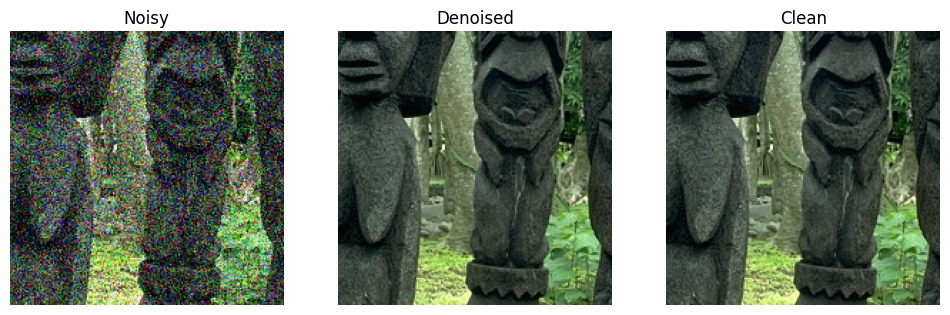

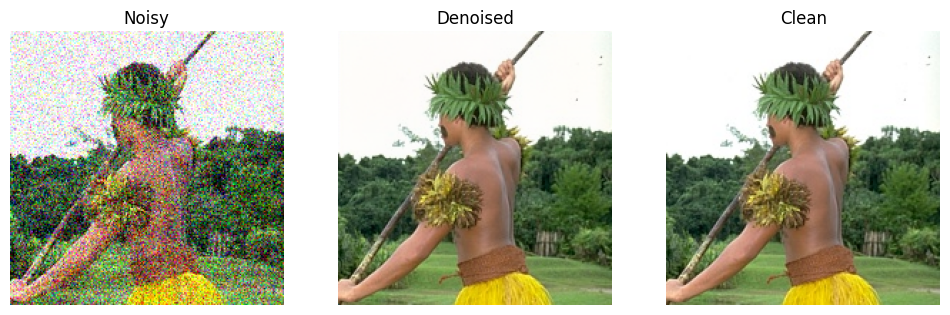

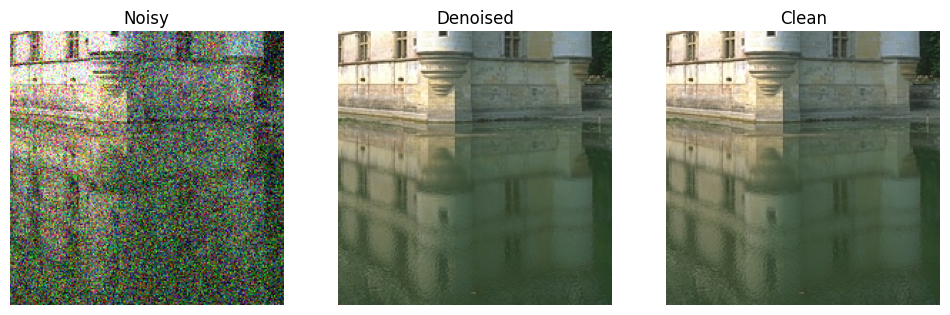

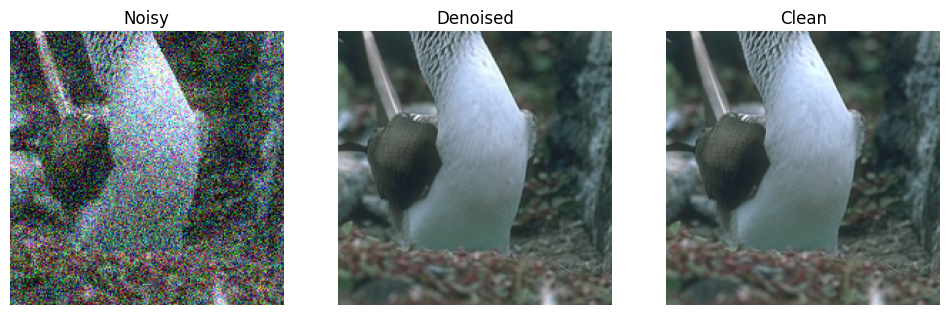

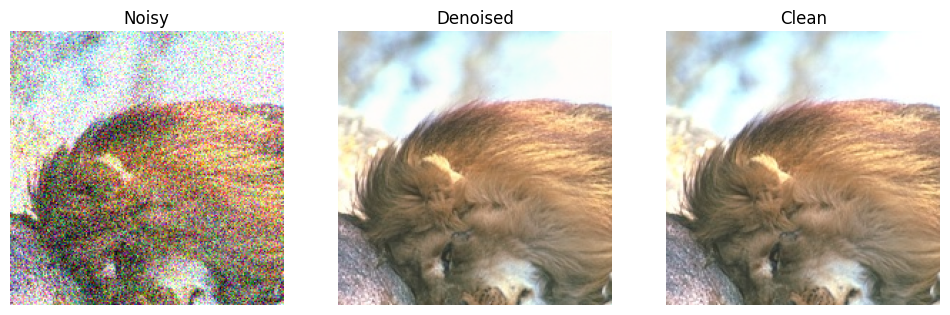

Average PSNR denoised: 44.9358
Average SSIM denoised: 0.9977
✅ All denoised images + model saved in results.zip (ready to download).


In [41]:

import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from PIL import Image
import zipfile
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim


os.makedirs("final_clean_outputs", exist_ok=True)

def tensor_to_img(t):
    return (t.permute(1,2,0).cpu().numpy() * 255.0).astype(np.uint8)

final_model_path = "checkpoints/drunet_final.pth"
model.load_state_dict(torch.load(final_model_path, map_location=DEVICE))
model.to(DEVICE)
model.eval()
print(f" Loaded model from {final_model_path}")

psnr_list, ssim_list = [], []

for idx in range(len(val_ds)):
    noisy_t, restormer_t, clean_t = val_ds[idx]

    with torch.no_grad():
        inp = torch.cat([noisy_t.unsqueeze(0), restormer_t.unsqueeze(0)], dim=1).to(DEVICE)
        out_res = model(inp)
        denoised = (inp[:, :3, :, :] - out_res).clamp(0.0, 1.0)


    noisy_img = tensor_to_img(noisy_t)
    denoised_img = tensor_to_img(denoised[0])
    clean_img = tensor_to_img(clean_t)


    out_path = f"final_clean_outputs/denoised_{idx:04d}.png"
    Image.fromarray(denoised_img).save(out_path)

    if idx < 5:
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.title("Noisy"); plt.axis('off'); plt.imshow(noisy_img)
        plt.subplot(1,3,2); plt.title("Denoised"); plt.axis('off'); plt.imshow(denoised_img)
        plt.subplot(1,3,3); plt.title("Clean"); plt.axis('off'); plt.imshow(clean_img)
        plt.show()

   
    noisy_f = noisy_img.astype(np.float32)/255.0
    den_f   = denoised_img.astype(np.float32)/255.0
    clean_f = clean_img.astype(np.float32)/255.0
    psnr_list.append(compute_psnr(clean_f, den_f, data_range=1.0))
    ssim_list.append(compute_ssim(clean_f, den_f, channel_axis=2, data_range=1.0))


print(f"Average PSNR denoised: {np.mean(psnr_list):.4f}")
print(f"Average SSIM denoised: {np.mean(ssim_list):.4f}")

torch.save(model.state_dict(), "model_final.pth")

with zipfile.ZipFile("results.zip", "w") as zipf:
    zipf.write("model_final.pth")
    for fname in os.listdir("final_clean_outputs"):
        zipf.write(os.path.join("final_clean_outputs", fname))

print(" All denoised images + model saved in results.zip (ready to download).")
